In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
from scipy.stats import norm

from math import sqrt, log, exp, cos, pi
from itertools import product

import multiprocessing as mp

import bspline
import bspline.splinelab as splinelab

import copy
import pickle

import os
path = os.path.join('..', 'src')

import sys
if path not in set(sys.path):
    sys.path.append(path)
from sab import falpha, SABC_HTE, SABC_ATE

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

# summarize results

In [347]:
suffix = ['_nonlinear.npz', '_nonlinear_adaptive.npz', '_nonlinear_LIL.npz', '_nonlinear_adaptive_LIL.npz']

nsim = 400
start_n = 1000 
typ_list = [2, 3] 
nk_list = [(200, 5), (20, 50)] 
delta_list = [0.0, 0.10, 0.15, 0.20, 0.25, 0.30] 
ms = [1, 2, 3]

index = pd.MultiIndex.from_product([typ_list, nk_list, delta_list], 
                                   names=['type', '(n, K)','delta'])
columns_sab = pd.MultiIndex.from_product([ms, ['rej_probs','E[stop]']], \
                                        names=['alpha_spending_methods','metrics'])

tbl, tbl_ = [], []

for sx in suffix:
    tbl_sab = pd.DataFrame(index=index, columns=columns_sab)
    tbl_sab_ = pd.DataFrame(index=index, columns=columns_sab)

    for (typ, (n, k), delta) in product(typ_list, nk_list, delta_list):
        name = 'result/HTE/'+'typ'+str(typ)+'n'+str(n)+'k'+str(k)+'delta'+str(delta)+ sx

        ns = np.ones(k)*n
        ns[0] = start_n    
        ns = ns.cumsum()

        if os.path.exists(name):
            res = np.load(name)

            mm = (res['rej_sabc'] > 0).mean(axis=0)
            vv = np.sqrt(mm*(1-mm)/nsim)
            stp = res['rej_sabc'].astype(np.int)
            stp[stp < 1] = k
            stp = ns[stp-1]*2

            stpm = stp.mean(axis=0)
            stpv = stp.std(axis=0)/sqrt(nsim)
            stpm = stpm.astype(np.int)
            stpv = stpv.astype(np.int)
            for l in range(lm):
                tbl_sab.loc[(typ, (n, k), delta), (ms[l], 'rej_probs')] = '{:3.1f}({:3.1f})'.format(mm[l]*100, vv[l]*100)
                tbl_sab.loc[(typ, (n, k), delta), (ms[l], 'E[stop]')]   = '{:d}({:d})'.format(stpm[l], stpv[l])

                tbl_sab_.loc[(typ, (n, k), delta), (ms[l], 'rej_probs')] = mm[l]*100
                tbl_sab_.loc[(typ, (n, k), delta), (ms[l], 'E[stop]')]   = stpm[l]

    tbl.append(copy.deepcopy(tbl_sab))
    tbl_.append(copy.deepcopy(tbl_sab_))    
    
with open('result/HTE.pkl', 'wb') as f:
    pickle.dump([tbl, tbl_], f)

In [385]:
suffix = ['_nonlinear_ATE.npz', '_nonlinear_adaptive_ATE.npz', '_nonlinear_AVT.npz', '_nonlinear_adaptive_AVT.npz']

nsim = 400
start_n = 500 
typ_list = [2, 3] 
nk_list = [(100, 5), (10, 50)] 
delta_list = [0.0, 0.10, 0.15, 0.20, 0.25, 0.30]
e = 1
ms = [1, 2, 3]

index = pd.MultiIndex.from_product([typ_list, nk_list, delta_list], 
                                   names=['type', '(n, K)','delta'])
columns_sab = pd.MultiIndex.from_product([ms, ['rej_probs','E[stop]']], \
                                        names=['alpha_spending_methods','metrics'])

tbl, tbl_ = [], []

for sx in suffix:
    tbl_sab = pd.DataFrame(index=index, columns=columns_sab)
    tbl_sab_ = pd.DataFrame(index=index, columns=columns_sab)

    for (typ, (n, k), delta) in product(typ_list, nk_list, delta_list):
        name = 'result/ATE/'+'typ'+str(typ)+'n'+str(n)+'k'+str(k)+'delta'+str(delta)+ sx

        ns = np.ones(k)*n
        ns[0] = start_n    
        ns = ns.cumsum()

        if os.path.exists(name):
            res = np.load(name)
            
            mm = (res['rej_sabc'] > 0).mean(axis=0)
            vv = np.sqrt(mm*(1-mm)/nsim)
            stp = res['rej_sabc'].astype(np.int)
            stp[stp < 1] = k
            stp = ns[stp-1]*2

            stpm = stp.mean(axis=0)
            stpv = stp.std(axis=0)/sqrt(nsim)
            stpm = stpm.astype(np.int)
            stpv = stpv.astype(np.int)
            for l in range(lm):
                tbl_sab.loc[(typ, (n, k), delta), (ms[l], 'rej_probs')] = '{:3.1f}({:3.1f})'.format(mm[l]*100, vv[l]*100)
                tbl_sab.loc[(typ, (n, k), delta), (ms[l], 'E[stop]')]   = '{:d}({:d})'.format(stpm[l], stpv[l])

                tbl_sab_.loc[(typ, (n, k), delta), (ms[l], 'rej_probs')] = mm[l]*100
                tbl_sab_.loc[(typ, (n, k), delta), (ms[l], 'E[stop]')]   = stpm[l]

    tbl.append(copy.deepcopy(tbl_sab))
    tbl_.append(copy.deepcopy(tbl_sab_))    
    
with open('result/ATE.pkl', 'wb') as f:
    pickle.dump([tbl, tbl_], f)

# simulation tables & figures

## HTE
- BS
- BS (adaptive)
- LIL
- LIL (adaptive)

In [449]:
with open('result/HTE.pkl', 'rb') as f:
    tbl, tbl_ = pickle.load(f)

In [450]:
# tbl1 = pd.concat([tbl[i][1] for i in range(4)], axis=1)
# tbl1.to_csv('latex.txt', sep='&', index=False)

In [451]:
tbl1 = pd.concat([tbl_[i][1] for i in range(4)], axis=1, ignore_index=True)
columns = pd.MultiIndex.from_product([['BAT','LIL'],['Random','Adaptive'],['rej_probs','E[stop]']])
tbl1.columns = columns

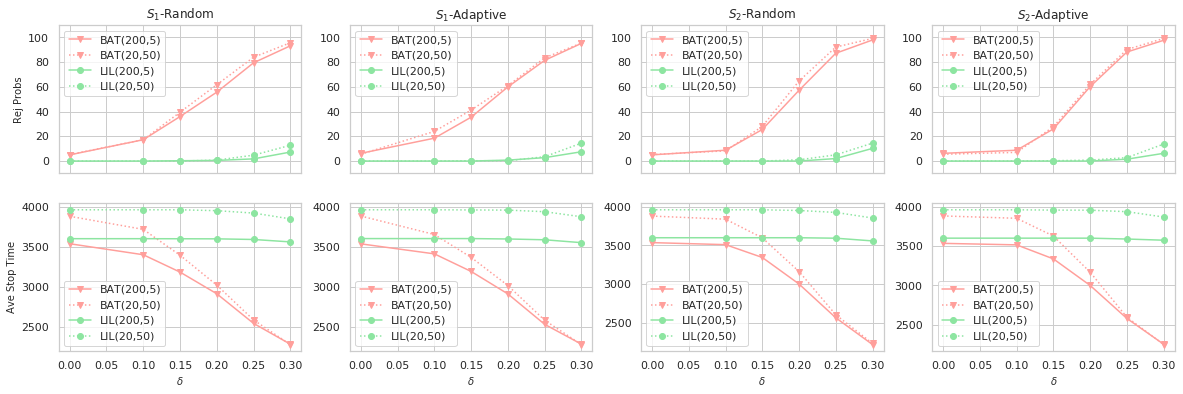

In [452]:
x = [0.0, 0.10, 0.15, 0.20, 0.25, 0.30]

fig, axes = plt.subplots(2, 4, figsize=(20, 6), sharex=True)

y1 = tbl1.loc[2].loc[(200,5)][('BAT','Random','rej_probs')].values
y2 = tbl1.loc[2].loc[(20,50)][('BAT','Random','rej_probs')].values
y3 = tbl1.loc[2].loc[(200,5)][('LIL','Random','rej_probs')].values
y4 = tbl1.loc[2].loc[(20,50)][('LIL','Random','rej_probs')].values
axes[0][0].plot(x, y1, color='r', ls='-', marker='v', label='BAT(200,5)')
axes[0][0].plot(x, y2, color='r', ls=':', marker='v', label='BAT(20,50)')
axes[0][0].plot(x, y3, color='g', ls='-', marker='o', label='LIL(200,5)')
axes[0][0].plot(x, y4, color='g', ls=':', marker='o', label='LIL(20,50)')
axes[0][0].legend(loc='upper left')
axes[0][0].set_ylim([-10, 110])
axes[0][0].set_title(r'$S_1$-Random')
y1 = tbl1.loc[2].loc[(200,5)][('BAT','Adaptive','rej_probs')].values
y2 = tbl1.loc[2].loc[(20,50)][('BAT','Adaptive','rej_probs')].values
y3 = tbl1.loc[2].loc[(200,5)][('LIL','Adaptive','rej_probs')].values
y4 = tbl1.loc[2].loc[(20,50)][('LIL','Adaptive','rej_probs')].values
axes[0][1].plot(x, y1, color='r', ls='-',  marker='v', label='BAT(200,5)')
axes[0][1].plot(x, y2, color='r', ls=':', marker='v', label='BAT(20,50)')
axes[0][1].plot(x, y3, color='g', ls='-',  marker='o', label='LIL(200,5)')
axes[0][1].plot(x, y4, color='g', ls=':', marker='o', label='LIL(20,50)')
axes[0][1].legend(loc='upper left')
axes[0][1].set_ylim([-10, 110])
axes[0][1].set_title(r'$S_1$-Adaptive')

y1 = tbl1.loc[3].loc[(200,5)][('BAT','Random','rej_probs')].values
y2 = tbl1.loc[3].loc[(20,50)][('BAT','Random','rej_probs')].values
y3 = tbl1.loc[3].loc[(200,5)][('LIL','Random','rej_probs')].values
y4 = tbl1.loc[3].loc[(20,50)][('LIL','Random','rej_probs')].values
axes[0][2].plot(x, y1, color='r', ls='-',  marker='v', label='BAT(200,5)')
axes[0][2].plot(x, y2, color='r', ls=':', marker='v', label='BAT(20,50)')
axes[0][2].plot(x, y3, color='g', ls='-',  marker='o', label='LIL(200,5)')
axes[0][2].plot(x, y4, color='g', ls=':', marker='o', label='LIL(20,50)')
axes[0][2].legend(loc='upper left')
axes[0][2].set_ylim([-10, 110])
axes[0][2].set_title(r'$S_2$-Random')
y1 = tbl1.loc[3].loc[(200,5)][('BAT','Adaptive','rej_probs')].values
y2 = tbl1.loc[3].loc[(20,50)][('BAT','Adaptive','rej_probs')].values
y3 = tbl1.loc[3].loc[(200,5)][('LIL','Adaptive','rej_probs')].values
y4 = tbl1.loc[3].loc[(20,50)][('LIL','Adaptive','rej_probs')].values
axes[0][3].plot(x, y1, color='r', ls='-',  marker='v', label='BAT(200,5)')
axes[0][3].plot(x, y2, color='r', ls=':', marker='v', label='BAT(20,50)')
axes[0][3].plot(x, y3, color='g', ls='-',  marker='o', label='LIL(200,5)')
axes[0][3].plot(x, y4, color='g', ls=':', marker='o', label='LIL(20,50)')
axes[0][3].legend(loc='upper left')
axes[0][3].set_ylim([-10, 110])
axes[0][3].set_title(r'$S_2$-Adaptive')


y1 = tbl1.loc[2].loc[(200,5)][('BAT','Random','E[stop]')].values
y2 = tbl1.loc[2].loc[(20,50)][('BAT','Random','E[stop]')].values
y3 = tbl1.loc[2].loc[(200,5)][('LIL','Random','E[stop]')].values
y4 = tbl1.loc[2].loc[(20,50)][('LIL','Random','E[stop]')].values
axes[1][0].plot(x, y1, color='r', ls='-',  marker='v', label='BAT(200,5)')
axes[1][0].plot(x, y2, color='r', ls=':', marker='v', label='BAT(20,50)')
axes[1][0].plot(x, y3, color='g', ls='-',  marker='o', label='LIL(200,5)')
axes[1][0].plot(x, y4, color='g', ls=':', marker='o', label='LIL(20,50)')
axes[1][0].legend(loc='lower left')
y1 = tbl1.loc[2].loc[(200,5)][('BAT','Adaptive','E[stop]')].values
y2 = tbl1.loc[2].loc[(20,50)][('BAT','Adaptive','E[stop]')].values
y3 = tbl1.loc[2].loc[(200,5)][('LIL','Adaptive','E[stop]')].values
y4 = tbl1.loc[2].loc[(20,50)][('LIL','Adaptive','E[stop]')].values
axes[1][1].plot(x, y1, color='r', ls='-',  marker='v', label='BAT(200,5)')
axes[1][1].plot(x, y2, color='r', ls=':', marker='v', label='BAT(20,50)')
axes[1][1].plot(x, y3, color='g', ls='-',  marker='o', label='LIL(200,5)')
axes[1][1].plot(x, y4, color='g', ls=':', marker='o', label='LIL(20,50)')
axes[1][1].legend(loc='lower left')

y1 = tbl1.loc[3].loc[(200,5)][('BAT','Random','E[stop]')].values
y2 = tbl1.loc[3].loc[(20,50)][('BAT','Random','E[stop]')].values
y3 = tbl1.loc[3].loc[(200,5)][('LIL','Random','E[stop]')].values
y4 = tbl1.loc[3].loc[(20,50)][('LIL','Random','E[stop]')].values
axes[1][2].plot(x, y1, color='r', ls='-',  marker='v', label='BAT(200,5)')
axes[1][2].plot(x, y2, color='r', ls=':', marker='v', label='BAT(20,50)')
axes[1][2].plot(x, y3, color='g', ls='-',  marker='o', label='LIL(200,5)')
axes[1][2].plot(x, y4, color='g', ls=':', marker='o', label='LIL(20,50)')
axes[1][2].legend(loc='lower left')
y1 = tbl1.loc[3].loc[(200,5)][('BAT','Adaptive','E[stop]')].values
y2 = tbl1.loc[3].loc[(20,50)][('BAT','Adaptive','E[stop]')].values
y3 = tbl1.loc[3].loc[(200,5)][('LIL','Adaptive','E[stop]')].values
y4 = tbl1.loc[3].loc[(20,50)][('LIL','Adaptive','E[stop]')].values
axes[1][3].plot(x, y1, color='r', ls='-',  marker='v', label='BAT(200,5)')
axes[1][3].plot(x, y2, color='r', ls=':', marker='v', label='BAT(20,50)')
axes[1][3].plot(x, y3, color='g', ls='-',  marker='o', label='LIL(200,5)')
axes[1][3].plot(x, y4, color='g', ls=':', marker='o', label='LIL(20,50)')
axes[1][3].legend(loc='lower left')

axes[0][0].set_ylabel('Rej Probs', fontsize=10)
axes[1][0].set_ylabel('Ave Stop Time', fontsize=10)
axes[1][0].set_xlabel(r'$\delta$', fontsize=10)
axes[1][1].set_xlabel(r'$\delta$', fontsize=10)
axes[1][2].set_xlabel(r'$\delta$', fontsize=10)
axes[1][3].set_xlabel(r'$\delta$', fontsize=10)

plt.savefig('fig/hte.png', dpi=200, bbox_inches='tight')

## ATE
- BS
- BS (adaptive)
- AVT
- AVT (adaptive)

In [460]:
with open('result/ATE.pkl', 'rb') as f:
    tbl, tbl_ = pickle.load(f)

In [461]:
# tbl1 = pd.concat([tbl[i][1] for i in range(4)], axis=1)
# tbl1.to_csv('latex.txt', sep='&')

In [462]:
tbl1 = pd.concat([tbl_[i][1] for i in range(4)], axis=1, ignore_index=True)
columns = pd.MultiIndex.from_product([['BAT','AVT'],['Random','Adaptive'],['rej_probs','E[stop]']])
tbl1.columns = columns

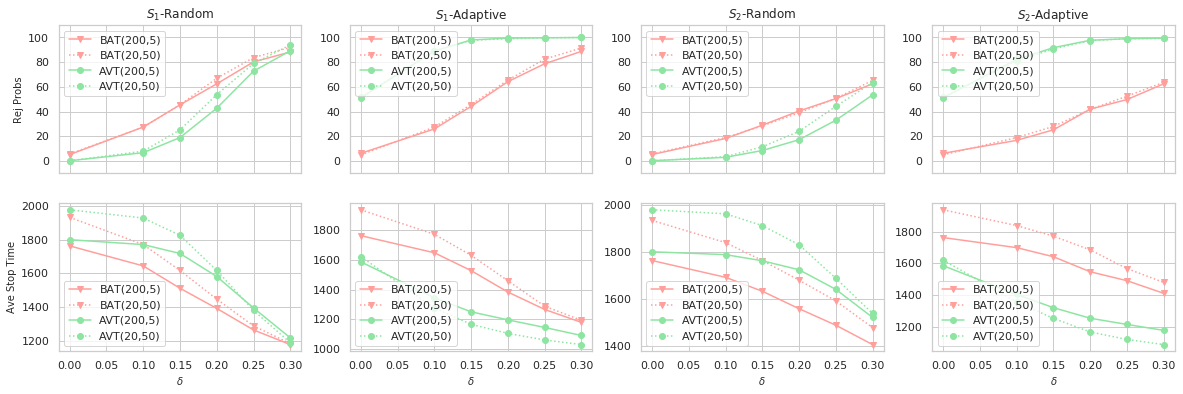

In [464]:
x = [0.0, 0.10, 0.15, 0.20, 0.25, 0.30]

fig, axes = plt.subplots(2, 4, figsize=(20, 6), sharex=True)

y1 = tbl1.loc[2].loc[(100,5)][('BAT','Random','rej_probs')].values
y2 = tbl1.loc[2].loc[(10,50)][('BAT','Random','rej_probs')].values
y3 = tbl1.loc[2].loc[(100,5)][('AVT','Random','rej_probs')].values
y4 = tbl1.loc[2].loc[(10,50)][('AVT','Random','rej_probs')].values
axes[0][0].plot(x, y1, color='r', ls='-', marker='v', label='BAT(200,5)')
axes[0][0].plot(x, y2, color='r', ls=':', marker='v', label='BAT(20,50)')
axes[0][0].plot(x, y3, color='g', ls='-', marker='o', label='AVT(200,5)')
axes[0][0].plot(x, y4, color='g', ls=':', marker='o', label='AVT(20,50)')
axes[0][0].legend(loc='upper left')
axes[0][0].set_ylim([-10, 110])
axes[0][0].set_title(r'$S_1$-Random')
y1 = tbl1.loc[2].loc[(100,5)][('BAT','Adaptive','rej_probs')].values
y2 = tbl1.loc[2].loc[(10,50)][('BAT','Adaptive','rej_probs')].values
y3 = tbl1.loc[2].loc[(100,5)][('AVT','Adaptive','rej_probs')].values
y4 = tbl1.loc[2].loc[(10,50)][('AVT','Adaptive','rej_probs')].values
axes[0][1].plot(x, y1, color='r', ls='-',  marker='v', label='BAT(200,5)')
axes[0][1].plot(x, y2, color='r', ls=':', marker='v', label='BAT(20,50)')
axes[0][1].plot(x, y3, color='g', ls='-',  marker='o', label='AVT(200,5)')
axes[0][1].plot(x, y4, color='g', ls=':', marker='o', label='AVT(20,50)')
axes[0][1].legend(loc='upper left')
axes[0][1].set_ylim([-10, 110])
axes[0][1].set_title(r'$S_1$-Adaptive')

y1 = tbl1.loc[3].loc[(100,5)][('BAT','Random','rej_probs')].values
y2 = tbl1.loc[3].loc[(10,50)][('BAT','Random','rej_probs')].values
y3 = tbl1.loc[3].loc[(100,5)][('AVT','Random','rej_probs')].values
y4 = tbl1.loc[3].loc[(10,50)][('AVT','Random','rej_probs')].values
axes[0][2].plot(x, y1, color='r', ls='-',  marker='v', label='BAT(200,5)')
axes[0][2].plot(x, y2, color='r', ls=':', marker='v', label='BAT(20,50)')
axes[0][2].plot(x, y3, color='g', ls='-',  marker='o', label='AVT(200,5)')
axes[0][2].plot(x, y4, color='g', ls=':', marker='o', label='AVT(20,50)')
axes[0][2].legend(loc='upper left')
axes[0][2].set_ylim([-10, 110])
axes[0][2].set_title(r'$S_2$-Random')
y1 = tbl1.loc[3].loc[(100,5)][('BAT','Adaptive','rej_probs')].values
y2 = tbl1.loc[3].loc[(10,50)][('BAT','Adaptive','rej_probs')].values
y3 = tbl1.loc[3].loc[(100,5)][('AVT','Adaptive','rej_probs')].values
y4 = tbl1.loc[3].loc[(10,50)][('AVT','Adaptive','rej_probs')].values
axes[0][3].plot(x, y1, color='r', ls='-',  marker='v', label='BAT(200,5)')
axes[0][3].plot(x, y2, color='r', ls=':', marker='v', label='BAT(20,50)')
axes[0][3].plot(x, y3, color='g', ls='-',  marker='o', label='AVT(200,5)')
axes[0][3].plot(x, y4, color='g', ls=':', marker='o', label='AVT(20,50)')
axes[0][3].legend(loc='upper left')
axes[0][3].set_ylim([-10, 110])
axes[0][3].set_title(r'$S_2$-Adaptive')


y1 = tbl1.loc[2].loc[(100,5)][('BAT','Random','E[stop]')].values
y2 = tbl1.loc[2].loc[(10,50)][('BAT','Random','E[stop]')].values
y3 = tbl1.loc[2].loc[(100,5)][('AVT','Random','E[stop]')].values
y4 = tbl1.loc[2].loc[(10,50)][('AVT','Random','E[stop]')].values
axes[1][0].plot(x, y1, color='r', ls='-',  marker='v', label='BAT(200,5)')
axes[1][0].plot(x, y2, color='r', ls=':', marker='v', label='BAT(20,50)')
axes[1][0].plot(x, y3, color='g', ls='-',  marker='o', label='AVT(200,5)')
axes[1][0].plot(x, y4, color='g', ls=':', marker='o', label='AVT(20,50)')
axes[1][0].legend(loc='lower left')
y1 = tbl1.loc[2].loc[(100,5)][('BAT','Adaptive','E[stop]')].values
y2 = tbl1.loc[2].loc[(10,50)][('BAT','Adaptive','E[stop]')].values
y3 = tbl1.loc[2].loc[(100,5)][('AVT','Adaptive','E[stop]')].values
y4 = tbl1.loc[2].loc[(10,50)][('AVT','Adaptive','E[stop]')].values
axes[1][1].plot(x, y1, color='r', ls='-',  marker='v', label='BAT(200,5)')
axes[1][1].plot(x, y2, color='r', ls=':', marker='v', label='BAT(20,50)')
axes[1][1].plot(x, y3, color='g', ls='-',  marker='o', label='AVT(200,5)')
axes[1][1].plot(x, y4, color='g', ls=':', marker='o', label='AVT(20,50)')
axes[1][1].legend(loc='lower left')

y1 = tbl1.loc[3].loc[(100,5)][('BAT','Random','E[stop]')].values
y2 = tbl1.loc[3].loc[(10,50)][('BAT','Random','E[stop]')].values
y3 = tbl1.loc[3].loc[(100,5)][('AVT','Random','E[stop]')].values
y4 = tbl1.loc[3].loc[(10,50)][('AVT','Random','E[stop]')].values
axes[1][2].plot(x, y1, color='r', ls='-',  marker='v', label='BAT(200,5)')
axes[1][2].plot(x, y2, color='r', ls=':', marker='v', label='BAT(20,50)')
axes[1][2].plot(x, y3, color='g', ls='-',  marker='o', label='AVT(200,5)')
axes[1][2].plot(x, y4, color='g', ls=':', marker='o', label='AVT(20,50)')
axes[1][2].legend(loc='lower left')
y1 = tbl1.loc[3].loc[(100,5)][('BAT','Adaptive','E[stop]')].values
y2 = tbl1.loc[3].loc[(10,50)][('BAT','Adaptive','E[stop]')].values
y3 = tbl1.loc[3].loc[(100,5)][('AVT','Adaptive','E[stop]')].values
y4 = tbl1.loc[3].loc[(10,50)][('AVT','Adaptive','E[stop]')].values
axes[1][3].plot(x, y1, color='r', ls='-',  marker='v', label='BAT(200,5)')
axes[1][3].plot(x, y2, color='r', ls=':', marker='v', label='BAT(20,50)')
axes[1][3].plot(x, y3, color='g', ls='-',  marker='o', label='AVT(200,5)')
axes[1][3].plot(x, y4, color='g', ls=':', marker='o', label='AVT(20,50)')
axes[1][3].legend(loc='lower left')

axes[0][0].set_ylabel('Rej Probs', fontsize=10)
axes[1][0].set_ylabel('Ave Stop Time', fontsize=10)
axes[1][0].set_xlabel(r'$\delta$', fontsize=10)
axes[1][1].set_xlabel(r'$\delta$', fontsize=10)
axes[1][2].set_xlabel(r'$\delta$', fontsize=10)
axes[1][3].set_xlabel(r'$\delta$', fontsize=10)

plt.savefig('fig/ate.png', dpi=200, bbox_inches='tight')